# 📚 PROYECTO AI-TEXTIFICATION
## 👅 Procesamiento de Lenguaje Natural
## 💻 Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
## 🏫 Universidad Nacional Autónoma de México

<hr>

### 🤖 AI-TEXTIFICATION
### 📓 CUADERNO [02]: EMBEDDINGS
### 📄 Detección de autoría en textos AI - Humanos:

#### 🔵 **Tarea A**: Clasificación Binaria:
1. Texto de Humano.
2. Texto de Inteligencia Artificial.

#### 🔵 **Tarea B**: Clasificación Multiclase:
1. Texto de ChatGPT.
2. Texto de Cohere.
3. Texto de Davinci.
4. Texto de Dolly.
5. Texto de Humano.

**👬 Autores:**
* León Rosas Manuel Alejandro.
* Ramos Herrera Iván Alejandro.


# [01] 🎯 Objetivo

**EN ESTE NOTEBOOK SE OBTENDRÁ EL DATASET LIMPIADOS Y SE LES APLICARÁN EMBEDDINGS [PROPIOS Y DE LA LIBRERÍA GENSIM] Y SE GUARDARÁN**.

**DATASETS:**
1. **PA: Cleaned => Lemma => UNK => GENSIM Embbedings**.
2. **PB: Cleaned => Lemma => UNK => OWN Embbedings**.
3. **PC: Cleaned => UNK => GENSIM Embbedings**.
4. **PD: Cleaned => UNK => OWN Embbeds**.

# [02] 📚 Datasets

## Obtención

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from utils import sigmoid, get_batches, compute_pca, get_dict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# [03] 🔳 Embeddings [A]

In [ ]:
# Dataset AB:
AB_train = pd.read_csv("/content/drive/MyDrive/Datasets/AITextification/TaskA-TrainAB.csv")
AB_test = pd.read_csv("/content/drive/MyDrive/Datasets/AITextification/TaskA-DevAB.csv")

# Dataset CD:
CD_train = pd.read_csv("/content/drive/MyDrive/Datasets/AITextification/TaskA-TrainCD.csv")
CD_test = pd.read_csv("/content/drive/MyDrive/Datasets/AITextification/TaskA-DevCD.csv")

## Implementaciones

### OWN EMBEDDINGS

In [ ]:
class Embeddings:

  # Constructor:
  def __init__(self, vocabulary_size: int, dimension: int):
    """
      ATTRIBUTES:
        - vocabulary_size [int]: Size of the vocabulary.
        - dimension [int]: Dimension of the hoped embedding.
    """
    self.V = vocabulary_size
    self.D = dimension

    # Initializate the Weights and Biases of the FFD NN for CBOW:
    # XAVIER INITIALIZATION:
    np.random.seed(11)
    self.W1 = np.random.randn(self.D, self.V) * np.sqrt(1 / self.V)
    self.W2 = np.random.randn(self.V, self.D) * np.sqrt(1 / self.D)
    self.b1 = np.zeros((self.D, 1))
    self.b2 = np.zeros((self.V, 1))
    self.grad_W1 = self.grad_W2 = self.grad_b1 = self.grad_b2 = None
    assert self.W1.shape == ((self.D, self.V))
    assert self.W2.shape == ((self.V, self.D))


  # Activation function:
  def softmax(self, x):
    """Returns the computation for Softmax(x), to the output layer"""
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)


  # FEEDFORWARD NEURAL NETWORK FUNCTIONS:
  def cost(self, y_real, y_predicted, batch_size):
    """Computes the Cross Entropy function(y_real, y_predicted, batch_size)"""
    logprobs = np.multiply(np.log(y_predicted),y_real) + np.multiply(np.log(1 - y_predicted), 1 - y_real)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost


  def forward(self, x):
    """Computes the Forward step on the FFD NN as Wx + b across the layer."""
    """[h1 = ReLU(W1 * x + b1)] => [a2 = (W2 * h1 + b2)]"""

    # Preactivation a1:
    a1 = self.W1 @ x + self.b1
    # h1 = ReLU(a1):
    h1 = np.maximum(0, a1)
    # Preactivation a2:
    a2 = self.W2 @ h1 + self.b2
    return a2, h1


  def backward(self, x, y_predicted, y_real, h, batch_size):
    """Computes Backrpopagation across Ouput Layer => a1"""
    # Layer 1:
    l1 = self.W2.T @ (y_predicted - y_real)
    # ReLu:
    l1 = np.maximum(0, l1)

    # Gradients:
    self.grad_W1 = (1 / batch_size) * np.dot(l1, x.T)
    self.grad_W2 = (1 / batch_size) * np.dot(y_predicted - y_real, h.T)
    self.grad_b1 = (1 / batch_size) * np.sum(l1, axis=1, keepdims=True)
    self.grad_b2 = (1 / batch_size) * np.sum(y_predicted - y_real, axis=1, keepdims=True)


  def embeddings(self, text, wordIndexes, iterations, learning_rate=0.001, batch_size=20):
    """Optimizator to update Weights and Biases using Gradient Descend and returns the embeddings (Weights)"""
    for x, y in get_batches(text, wordIndexes, self.V, 2, batch_size):
      # Forward Step:
      a2, h1 = self.forward(x)
      # Prediction:
      y_predicted = self.softmax(a2)
      # Cost:
      cost = -np.sum(y * np.log(y_predicted)) / batch_size
      # if ((iterations+1) % 10 == 0):
      #  print(f"iterations: {iterations + 1} cost: {cost:.6f}")
      # Backpropagation step:
      self.backward(x, y_predicted, y, h1, batch_size)

      # Updating the Weights and Biases:
      self.W1 -= learning_rate * self.grad_W1
      self.W2 -= learning_rate * self.grad_W2
      self.b1 -= learning_rate * self.grad_b1
      self.b2 -= learning_rate * self.grad_b2

      iterations += 1
      if iterations == iterations:
          break
      if iterations % 100 == 0:
          learning_rate *= 0.66

    # Returns the embeddings:
    return (self.W1.T + self.W2) / 2.0


  def get_embedding_of(self, word, word2Index):
    """
    Obtiene el embedding para una palabra específica.

    Parameters:
    - word (str): La palabra para la cual se desea obtener el embedding.
    - word2Index (dict): Diccionario que mapea palabras a índices.

    Returns:
    - np.ndarray: El embedding correspondiente a la palabra.
    """
    if word in word2Index:
      word_index = word2Index[word]
      print(f"Índice de la palabra \"{word}\": {word_index}")

      embedding = (self.W1.T[word_index] + self.W2[word_index]) / 2.0
      print(f"Embedding calculado: {embedding}")

      return embedding
    else:
      print(f"La palabra \"{word}\" no está en el vocabulario.")
      print(word)
      return np.zeros(self.D)


  def view_embeddings(self, words, word2Index):
    from matplotlib import pyplot
    valid_indices = [word2Index[word] for word in words if word in word2Index]

    X = embedsitos[valid_indices, :]
    print(X.shape, valid_indices)

    result = compute_pca(X, 2)

    pyplot.scatter(result[:, 0], result[:, 1])

    for i, word in enumerate(words):
        if word in word2Index:
            idx = valid_indices.index(word2Index[word])
            pyplot.annotate(word, xy=(result[idx, 0], result[idx, 1]))

    pyplot.show()

In [ ]:
def own_embeddings(dataframe, text_column="text", dimensions=50, iterations=1000, learning_rate=0.001, batch_size=1):
  # Obtiene el diccionario de palabras:
  whole_text = " ".join(dataframe[text_column])
  tokens = word_tokenize(whole_text)
  tokens.append(" ")
  word2Index, _ = get_dict(tokens)
  print("Tamaño del vocabulario:", len(word2Index))

  # Inicializa el objeto de embeddings:
  EMB = Embeddings(vocabulary_size=len(word2Index), dimension=dimensions)

  # Obtiene embeddings para toda la columna en el DataFrame:
  embeddings = EMB.embeddings(whole_text, word2Index, iterations, learning_rate)

  return embeddings, word2Index, EMB

#### Ejemplo de uso

Tamaño del vocabulario: 18887
(18887, 50)
Índice de la palabra "computer": 4177
Embedding calculado: [ 0.045846   -0.05224661  0.09487325  0.06001613  0.01304955 -0.0674416
 -0.04988113 -0.06065706 -0.04037847 -0.04839922  0.05238548  0.07383298
 -0.02626773 -0.00044722 -0.05665265 -0.10181015 -0.0797675   0.07552308
  0.02023089 -0.0915984   0.00552453  0.01035424  0.01675895 -0.01054961
  0.011903   -0.04685713  0.03256091 -0.06374772 -0.00129824 -0.01877435
  0.01408439 -0.10200335  0.03171838  0.0381566  -0.01531156 -0.06592213
 -0.04305332 -0.00167716  0.05010012  0.01306855 -0.07377424 -0.03814982
  0.04244974 -0.16680745 -0.00260824 -0.02935439 -0.00689167  0.05153336
 -0.02121076  0.0084323 ]
(10, 50) [4177, 9802, 13683, 9803, 8123, 14822, 5693, 14773, 15024, 17785]


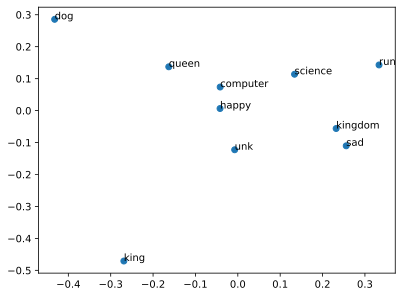

In [ ]:
embedsitos, word2Index, emb = own_embeddings(AB_test, iterations=2000, learning_rate=0.0001)
print(embedsitos.shape)
emb.get_embedding_of("computer", word2Index)
view_words = ["computer", "king", "queen", "kingdom", "happy", "sad", "dog", "run", "science", "lolxd", "unk"]
emb.view_embeddings(view_words, word2Index)

### PYTHON LIBRARY EMBEDDINGS

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [ ]:
# Tokenize the sentences:
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in lines]

# Train Word2Vec model:
model = Word2Vec(sentences=tokenized_sentences, vector_size=50, window=5, min_count=1, workers=4)

# Save the model:
model.save("word2vec.model")

# Get the word vector for a specific word:
word_vector = model.wv["little"]
print(f"Vector for \"little\": {word_vector}")

# Similarity between two words:
similarity = model.wv.similarity("kingdom", "king")
print(f"Similarity between \"kingdom\" and \"king\": {similarity}")

Vector for "little": [-0.00635842 -0.06396496  0.00608176  0.07513064 -0.10107178 -0.1780544
  0.14216593  0.33434093 -0.24632278 -0.16182567  0.04969298 -0.21819204
  0.03386923  0.22442748 -0.13066857  0.12986629  0.15950257  0.00782079
 -0.36780035 -0.1717765   0.01976203  0.20504047  0.3643737   0.00560989
  0.04927661  0.04978066  0.00109018 -0.00640525 -0.11617131  0.03706574
  0.1437774  -0.10265845 -0.0465221  -0.16134077 -0.04047582  0.09819089
  0.2401363   0.01229743  0.14250459 -0.10995676  0.24078216 -0.04479929
 -0.0719698   0.00566156  0.41558087  0.11065891 -0.08807793  0.01718168
  0.13502286  0.04408467]
Similarity between "kingdom" and "king": 0.9445829391479492


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def gensim_embeddings(dataframe, text_column="text", dimensions=50, window=5, min_count=1, workers=4):
  # Tokeniza el texto:
  tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in dataframe[text_column]]

  # Entrenar el modelo Word2Vec:
  model = Word2Vec(sentences=tokenized_sentences, vector_size=dimensions, window=window, min_count=min_count, workers=workers)

  # Obtener embeddings para cada texto en el DataFrame:
  dataframe["embeddings"] = dataframe[text_column].apply(lambda text: get_embeddings(text, model))

  return dataframe, model


def get_embeddings(text, model):
  # Tokeniza y procesa el texto:
  tokens = word_tokenize(text.lower())

  # Obtiene el vector promedio de embeddings de palabras:
  embeddings = [model.wv[token] for token in tokens if token in model.wv]
  if not embeddings:
    # Si no hay embeddings, retornar un vector de ceros:
    return np.zeros(model.vector_size)
  return np.mean(embeddings, axis=0)


def view_gensim(words, model):
  valid_words = [word for word in words if word in model.wv]

  # Obtiene los embeddings para las palabras válidas:
  X = [model.wv[word] for word in valid_words]
  X = np.array(X)

  print(X.shape, valid_words)

  # Aplica PCA a los embeddings:
  pca = PCA(n_components=2)
  result = pca.fit_transform(X)

  # Visualiza los embeddings:
  plt.scatter(result[:, 0], result[:, 1])
  for i, word in enumerate(valid_words):
    idx = words.index(word)
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
  plt.show()

#### Ejemplo de uso

(5000,)
Vector para "computer":
 [ 0.01872814  0.61278784 -0.8637215   0.6796528  -1.9468354  -1.0770389
  0.79480714  0.4223309  -2.151323    0.47885495  0.05581171 -1.134505
  0.68822086  1.0381188   2.0538232  -0.99861145 -0.2788916  -0.9172653
  0.48028585 -1.6959043  -0.1866316  -0.41082233  0.77889043  0.28801018
  0.9204819  -0.6734427   0.8454199  -0.36540842  1.1906438  -0.8396483
 -0.30666092  0.55653465  0.45937142  0.9032368  -0.4742202  -1.2499065
 -0.38450286  1.1851611  -0.7325303  -0.8080676   0.89294076  0.05001917
 -0.02660507 -0.03860467  1.3522491   1.244368   -0.26224878 -0.7421615
  0.3430547   1.0515698 ]
(10, 50) ['computer', 'king', 'queen', 'kingdom', 'happy', 'sad', 'dog', 'run', 'science', 'unk']


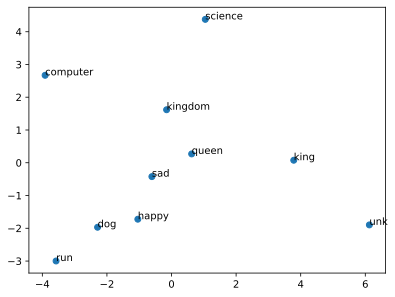

In [ ]:
df_gensim, model_gensim = gensim_embeddings(AB_test, dimensions=50, window=5, min_count=1, workers=4)
print(df_gensim["embeddings"].shape)
print("Vector para \"computer\":\n", model_gensim.wv["computer"])

view_words = ["computer", "king", "queen", "kingdom", "happy", "sad", "dog", "run", "science", "lolxd", "unk"]
view_gensim(view_words, model_gensim)

## Embeddings de Datasets

### [A]

In [ ]:
# Embeddings A: Dataset AB => Embeddings Gensim:
A_gensim_df, A_gensim_model = gensim_embeddings(AB_train, dimensions=50, window=5, min_count=1, workers=4)

In [ ]:
A_gensim_model.save("/content/drive/MyDrive/Datasets/AITextification/A_gensim_model.bin")
A_gensim_df["embeddings"].to_csv("/content/drive/MyDrive/Datasets/AITextification/A_gensim_embeddings.csv", index=False)

### [B]

In [ ]:
# Embeddings B: Dataset AB => Embeddings Propios:
B_embeds, B_word2Index, B_embeds_model = own_embeddings(AB_train, iterations=2000, learning_rate=0.0001)

Tamaño del vocabulario: 123381


In [ ]:
import pickle

with open("/content/drive/MyDrive/Datasets/AITextification/B_embeds_model.pkl", "wb") as model_file:
    pickle.dump(B_embeds_model, model_file)

with open("/content/drive/MyDrive/Datasets/AITextification/B_word2Index.pkl", "wb") as word2Index_file:
    pickle.dump(B_word2Index, word2Index_file)

pd.DataFrame(B_embeds).to_csv("/content/drive/MyDrive/Datasets/AITextification/B_embeds.csv", index=False)

### [C]

In [ ]:
# Embeddings C: Dataset CD => Embeddings Gensim:
C_gensim_df, C_gensim_model = gensim_embeddings(CD_train, dimensions=50, window=5, min_count=1, workers=4)

In [ ]:
C_gensim_model.save("/content/drive/MyDrive/Datasets/AITextification/C_gensim_model.bin")
C_gensim_df["embeddings"].to_csv("/content/drive/MyDrive/Datasets/AITextification/C_gensim_embeddings.csv", index=False)

### [D]

In [ ]:
# Embeddings D: Dataset CD => Embeddings Propios:
D_embeds, D_word2Index, D_embeds_model = own_embeddings(CD_train, iterations=2000, learning_rate=0.0001)

Tamaño del vocabulario: 135214


In [ ]:
import pickle

with open("/content/drive/MyDrive/Datasets/AITextification/D_embeds_model.pkl", "wb") as model_file:
    pickle.dump(D_embeds_model, model_file)

with open("/content/drive/MyDrive/Datasets/AITextification/D_word2Index.pkl", "wb") as word2Index_file:
    pickle.dump(D_word2Index, word2Index_file)

pd.DataFrame(D_embeds).to_csv("/content/drive/MyDrive/Datasets/AITextification/D_embeds.csv", index=False)

# [04] 🔳 Embeddings [B]

In [ ]:
# Dataset AB:
TaskB_AB_train = pd.read_csv("/content/drive/MyDrive/Datasets/AITextification/TaskB-TrainAB.csv")
# AB_test = pd.read_csv("/content/drive/MyDrive/Datasets/AITextification/TaskB-DevAB.csv")

# Dataset CD:
TaskB_CD_train = pd.read_csv("/content/drive/MyDrive/Datasets/AITextification/TaskB-TrainCD.csv")
# CD_test = pd.read_csv("/content/drive/MyDrive/Datasets/AITextification/TaskB-DevCD.csv")

## Embeddings de Datasets

### [A]

In [ ]:
# Embeddings A: Dataset AB => Embeddings Gensim:
TB_A_gensim_df, TB_A_gensim_model = gensim_embeddings(TaskB_AB_train, dimensions=50, window=5, min_count=1, workers=4)

In [ ]:
TB_A_gensim_model.save("/content/drive/MyDrive/Datasets/AITextification/TaskB_A_gensim_model.bin")
TB_A_gensim_df["embeddings"].to_csv("/content/drive/MyDrive/Datasets/AITextification/TaskB_A_gensim_embeddings.csv", index=False)

### [B]

In [ ]:
# Embeddings B: Dataset AB => Embeddings Propios:
TB_B_embeds, TB_B_word2Index, TB_B_embeds_model = own_embeddings(TaskB_AB_train, iterations=2000, learning_rate=0.0001)

Tamaño del vocabulario: 68731


In [ ]:
import pickle

with open("/content/drive/MyDrive/Datasets/AITextification/TaskB_B_embeds_model.pkl", "wb") as model_file:
    pickle.dump(TB_B_embeds_model, model_file)

with open("/content/drive/MyDrive/Datasets/AITextification/TaskB_B_word2Index.pkl", "wb") as word2Index_file:
    pickle.dump(TB_B_word2Index, word2Index_file)

pd.DataFrame(TB_B_embeds).to_csv("/content/drive/MyDrive/Datasets/AITextification/TB_B_embeds.csv", index=False)

### [C]

In [ ]:
# Embeddings C: Dataset CD => Embeddings Gensim:
TB_C_gensim_df, TB_C_gensim_model = gensim_embeddings(TaskB_CD_train, dimensions=50, window=5, min_count=1, workers=4)

In [ ]:
TB_C_gensim_model.save("/content/drive/MyDrive/Datasets/AITextification/TB_C_gensim_model.bin")
TB_C_gensim_df["embeddings"].to_csv("/content/drive/MyDrive/Datasets/AITextification/TB_C_gensim_embeddings.csv", index=False)

### [D]

In [ ]:
# Embeddings D: Dataset CD => Embeddings Propios:
TB_D_embeds, TB_D_word2Index, TB_D_embeds_model = own_embeddings(TaskB_CD_train, iterations=2000, learning_rate=0.0001)

Tamaño del vocabulario: 76948


In [ ]:
import pickle

with open("/content/drive/MyDrive/Datasets/AITextification/TB_D_embeds_model.pkl", "wb") as model_file:
    pickle.dump(TB_D_embeds_model, model_file)

with open("/content/drive/MyDrive/Datasets/AITextification/TB_D_word2Index.pkl", "wb") as word2Index_file:
    pickle.dump(TB_D_word2Index, word2Index_file)

pd.DataFrame(TB_D_embeds).to_csv("/content/drive/MyDrive/Datasets/AITextification/TB_D_embeds.csv", index=False)

# [04] 👬 Autores
## Realizado por:
* León Rosas Manuel Alejandro.
* Ramos Herrera Iván Alejandro.